# 4 Pre-Processing and Training Data Development<a id='2_Data_Wrangling'></a>

### 4.1 Table of Contents<a id='4.1_Contents'></a>
* [4.1 Table of Contents](#4.1_Table_Contents)  
* [4.2 Introduction](#4.2_Introduction)
* [4.3 Libraries that will be used](#4.3_Libraries_that_will_be_used)
* [4.4 Loading the data](#4.4_Loading_the_data)
* [4.5 Minimal EDA](#4.5_Minimal_EDA) 
    * [4.5.1 Transformation of categorical features](#4.5.1_Transformation_of_categorical_features)
    * [4.5.2 Portoin of clesses](#4.5.2_Portion_of_clesses)
    * [4.5.3 Scatter plot of Blood Pressure vs. Cholesterol Level](#4.5.3_Scatter)
    * [4.5.4  Model building cycle](#4.5.4_Model_building_cycle) 
    * [4.5.5 Comments on this result](#4.5.5_Comments)
* [5.1 Building a Logistic Regression Model with all featues](#5.1_Building_LReg) 
    * [5.1.1 Defining x and y](#5.1.1_Building_LReg)
    * [5.1.2 Perform train/test Split](#5.1.2_Perform)
    * [5.1.3 Create an object of the class associated with the algorithm](#5.1.3_Create_an_object.) 
    * [5.1.4 Build an actual model using the 'fit'](#5.1.4_Build_using_fit)
    * [5.1.5 Predict with the built model using the predict](#5.1.5_Predict)
    * [5.1.6 Compute performance metrics](#5.1.6_Compute_metrix)
    * [5.1.7 Determine if model can be improve](#5.1.7_Determine)
* [5.2 Side-Bar ](#5.2_Side-bar)
* [5.3 Summary](#5.3_Summary)

#### 4.2 Introduction

In Processing and Training Data Development, we won't complete all the steps, In Data Scince Process this is the fourt step will be addressed as we deal with categorial variables later and split the data into training, validation, and test sets. Most of your time will be spend on Step Five, Modeling. In a complete project, you would often prepare a report or some presentation materials for Step Six, but will not do that here.

#### 4.3 Libraries that will be used

In [1]:
%matplotlib inline
#
# data manipulation and math
#
import numpy as np
import scipy as sp
import pandas as pd
#
# plotting and visualization
#
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
#
import seaborn as sns
#
# modeling
#
from sklearn.preprocessing import OneHotEncoder as OHE
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


For the final preparation step, we provide two utility functions that we will use to illustrate the concepts of classification through logistic regression. 

By putting this code in functions, it will be easier to re-use, maintain, and fine-tune over time. 

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#
plt.rcParams['figure.figsize'] = (3, 3)
plt.style.use('seaborn-pastel')
plt.rcParams['figure.dpi'] = 150      
#
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]
#
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
#

In [3]:
def points_plot(ax, Xtr, Xte, ytr, yte, 
                clf, 
                mesh = True, colorscale = cmap_light, cdiscrete = cmap_bold, 
                alpha = 0.1, psize = 10, 
                zfunc = False, predicted = False):
#
# note: this function only works for X.shape = (:, 2)
# it is intended to illustrate the classifier boundary
#
# get the column names if they exist to apply
# to the meshed data generated below
#
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#
    h = 0.02
#
# create a uniform grid spanning the range of the X values
# note that y here is NOT the target, it is the 2nd
# dimension of the desired plot
#
    X = np.concatenate((Xtrain, Xtest))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
#
# predict the target value at each point in the grid
#
# this method uses the probabilities from the classifier
# and applies a function to determine the class
#
    if zfunc:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                         columns = feature_names)
        p0 = clf.predict_proba(mesh_data)[:, 0]
        p1 = clf.predict_proba(mesh_data)[:, 1]
        Z = zfunc(p0, p1)
#
# this method uses the classifier to predict the classes directly
#
    else:
        mesh_data = np.c_[xx.ravel(), yy.ravel()]
        if feature_names is not None:
            mesh_data = pd.DataFrame(mesh_data, 
                                     columns = feature_names)
        Z = clf.predict(mesh_data)
    ZZ = Z.reshape(xx.shape)
#
# plt.pcolormesh() creates a shaded result over the grid
#
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, 
                       cmap = cmap_light, 
                       alpha = alpha, 
                       axes = ax, 
                       shading = 'auto')
#
# add the points to the plot
# these can be the original target values
# or the predicted values
#
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
#
# plot training points
#
    ax.scatter(Xtrain[:, 0], Xtrain[:, 1], 
               c = showtr - 1, 
               cmap = cmap_bold, 
               s = psize, 
               alpha = alpha, 
               edgecolor = "k")
#    
# plot testing points
#
    ax.scatter(Xtest[:, 0], Xtest[:, 1],
               c = showte - 1, 
               cmap = cmap_bold, 
               s = psize + 10,
               alpha = alpha, 
               marker = "s")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
#
    return ax, xx, yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, 
                     clf, colorscale = cmap_light, cdiscrete = cmap_bold, 
                     ccolor = cm, 
                     alpha = 0.1, psize = 10):
    try:
        feature_names = Xtr.columns
    except:
        feature_names = None
#        
    Xtrain = np.array(Xtr)
    Xtest = np.array(Xte)
#    
    ax, xx, yy = points_plot(ax, Xtr, Xte, ytr, yte,
                         clf,
                         mesh = False, 
                         colorscale = colorscale, cdiscrete = cdiscrete, 
                         psize = psize, alpha = alpha,
                         predicted = True) 
    mesh_data = np.c_[xx.ravel(), yy.ravel()]
    if feature_names is not None:
        mesh_data = pd.DataFrame(mesh_data, 
                     columns = feature_names)    
    Z = clf.predict_proba(mesh_data)[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap = ccolor, alpha = 0.2)
    cs2 = plt.contour(xx, yy, Z, cmap = ccolor, alpha = 0.6)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize = 12)
#
    plt.show()

#### 4.4 Loading the data

As a first step, read in the data and view all the columns, and display the top of the DataFrame using head().

In [5]:
df = pd.read_csv('/Users/aquinojoeanson/Desktop/SPRINGBOARD/Capstone_Project_2/Data/sample.csv')

# Change num values > 0 to 1 for a Diagnosis to get our data ready for the next steps.
df['num'] = np.where((df['num']>0),1,0)

#
print('The data have ', df.shape[0], ' rows and ', df.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df.columns)))

The data have  297  rows and  14  columns

column names: 

age
sex
cp
trestbps
chol
fbs
restecg
thalach
exang
oldpeak
slope
ca
thal
num


In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


#### 4.5 Minimal EDA

For Full EDA please see "Capstone_Project_3_Exploratory_Data_Analysis.ipynb".
After examining the first few rows of the data, plotting the variables, applying some transformations, and inspecting the distribution, we can estimate the proportion of patients who have heart disease.

In [7]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


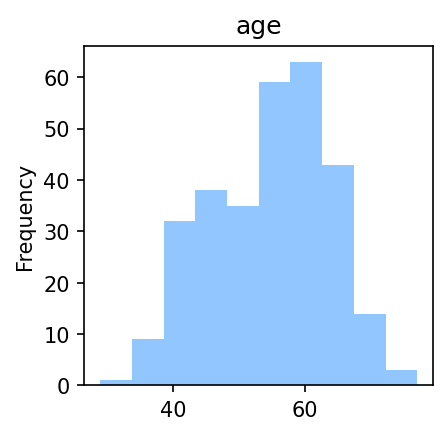

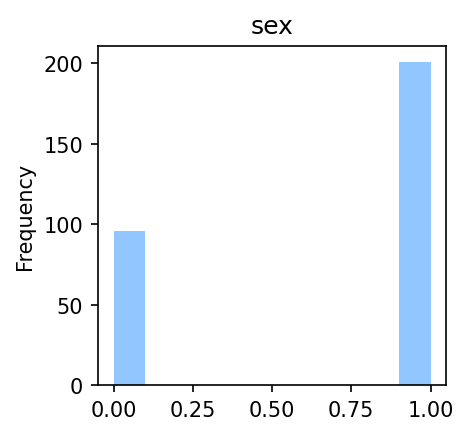

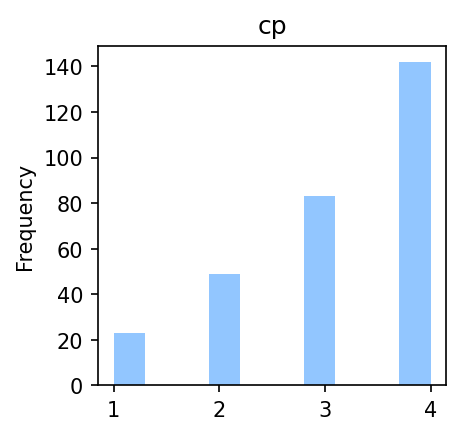

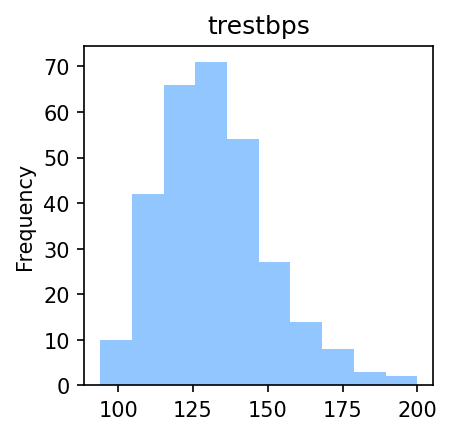

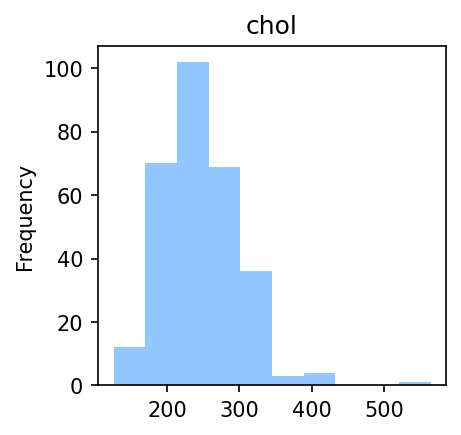

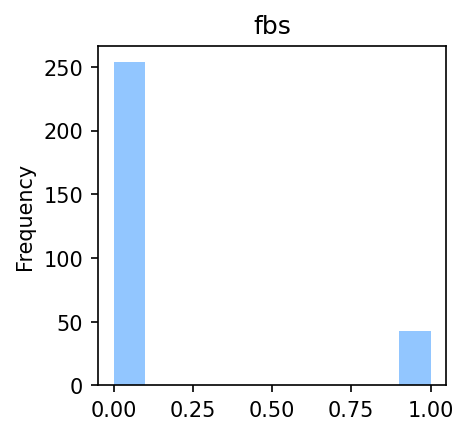

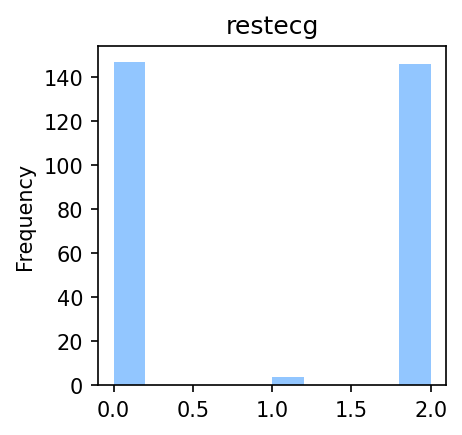

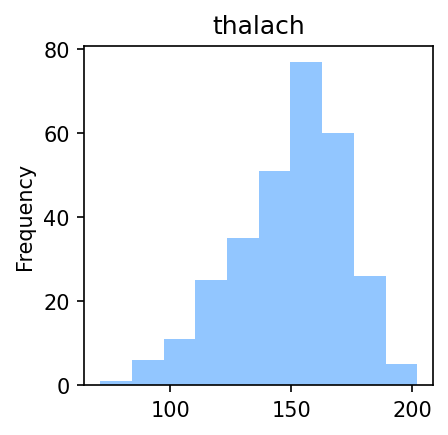

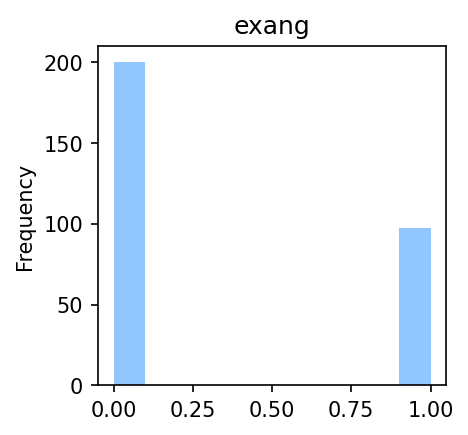

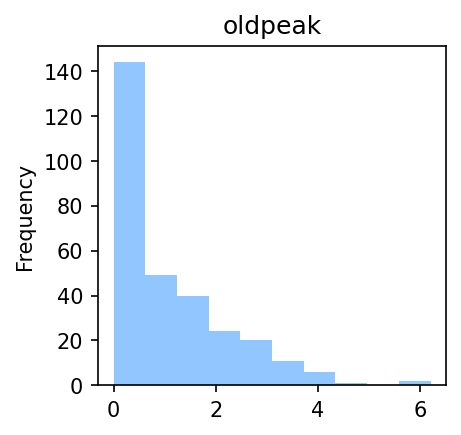

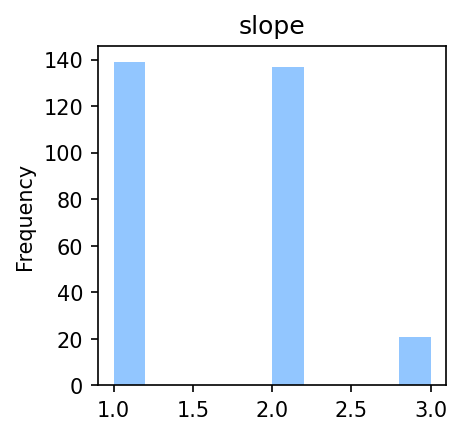

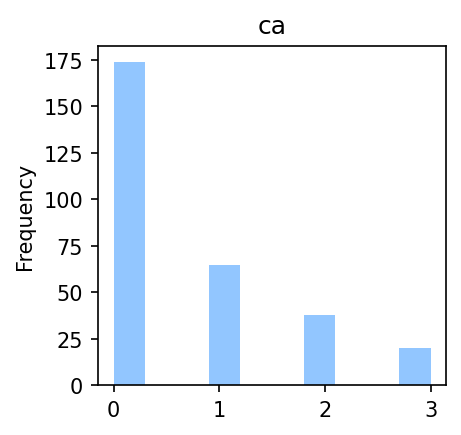

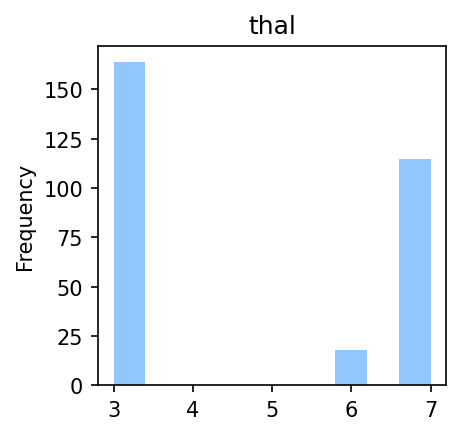

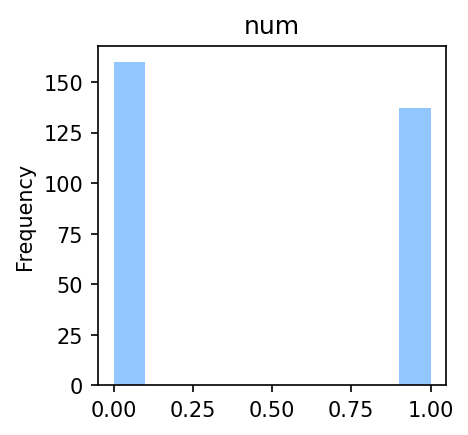

In [8]:
for col in list(df.columns):
    df[col].plot(kind = 'hist', title = col)
    plt.show()

Without completing a full EDA, we can see that some variables take on values that denote classes or categories (such as sex, bps), and thus are categorical, and some take on values that are a measure (such as age, trestbps, chol) and therefore are non-categorical, possibly scaling some of the variables, and generally ensuring you understand the data and they are suitable for a given model, to mention only a few. Here, we will need to transform the categorical values to use them in a logistic regression model.

Before moving on to modeling, let's look at some of the features of the dataset.

In [9]:
#
# extract the age as a Series, and inspect the values
#
x = df['age']
print('first 6 lines of age data:\n', x.head(6))
print('\nsummary statistics of age:\n', x.describe())

first 6 lines of age data:
 0    63
1    67
2    67
3    37
4    41
5    56
Name: age, dtype: int64

summary statistics of age:
 count    297.000000
mean      54.542088
std        9.049736
min       29.000000
25%       48.000000
50%       56.000000
75%       61.000000
max       77.000000
Name: age, dtype: float64


In [10]:
#
# do the same for the resting blood pressure
#
y = df['trestbps']
print('first six lines of blood pressure data:\n', y.head(6))
print('\nsummary statistics of blood pressure:\n', y.describe())

first six lines of blood pressure data:
 0    145
1    160
2    120
3    130
4    130
5    120
Name: trestbps, dtype: int64

summary statistics of blood pressure:
 count    297.000000
mean     131.693603
std       17.762806
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64


#### 4.5.1 Transformation of categorical features
Create dummy or indicator features for categorical variables


In [11]:
categorical_features = ['sex',
                        'cp',
                        'restecg',
                        'slope',
                        'thal']
df = pd.get_dummies(df, columns = categorical_features)
print('The data have ', df.shape[0], ' rows and ', df.shape[1], ' columns\n')
print('column names: \n')
print('\n'.join(list(df.columns)))

The data have  297  rows and  24  columns

column names: 

age
trestbps
chol
fbs
thalach
exang
oldpeak
ca
num
sex_0
sex_1
cp_1
cp_2
cp_3
cp_4
restecg_0
restecg_1
restecg_2
slope_1
slope_2
slope_3
thal_3
thal_6
thal_7


#### 4.5.2 Proportion of classes
When building classification models, it is always a good idea to know right away the number of samples per class, proportionally to the total number of samples. First we get the counts of each class.

In [12]:
class_counts = df['num'].value_counts()
class_counts

0    160
1    137
Name: num, dtype: int64

In [13]:
type(class_counts)

pandas.core.series.Series

To better quantify differences in the incidences of the classes, we compute the relative frequencies (percentages) 

In [14]:
class_percentages = pd.Series([(x / df.shape[0]) * 100.00 for x in class_counts])
class_percentages

0    53.872054
1    46.127946
dtype: float64

We can use the percentages as labels and plot the distribution of the two classes:

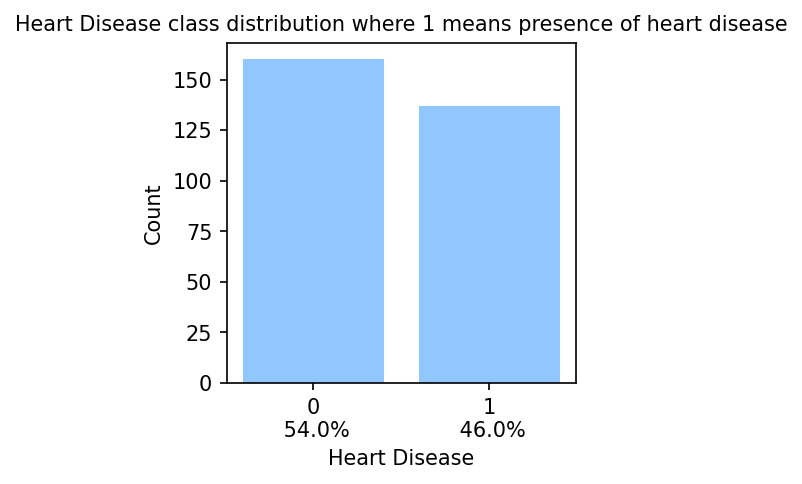

In [15]:
fig, ax = plt.subplots()
ax.bar(class_counts.index, class_counts)
ax.set_xticks([0, 1])
ax.set_xticklabels(class_percentages.index.astype(str) + '\n' + ' ' +
                   class_percentages.round(0).astype(str) + '%')
ax.set_ylabel('Count')
ax.set_xlabel('Heart Disease')
ax.set_title('Heart Disease class distribution where 1 means presence of heart disease',
              fontsize = 10)
plt.show()

#### 4.5.3 Ceate a scatter plot of Blood Pressure vs. Cholesterol Level
Color the points differently by the Presence of Heart Disease

Let's re-call our features:( we are choosing chol and 
```
age
trestbps
chol
fbs
thalach
exang
oldpeak
ca
num
sex_0
sex_1
cp_1
cp_2
cp_3
cp_4
restecg_0
restecg_1
restecg_2
slope_1
slope_2
slope_3
thal_3
thal_6
thal_7
```

#### 4.5.4 Model building cycle
Split your data into testing and training datasets

how the parameters passed to train_test_split are computed "on-the-fly", what their types are expected to be, and what are the values of the parameters that are not passed explicitly, which will take the default values per the documentation of the method train_test_split ... 

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(df[['chol','trestbps']],
                                                df['num'],
                                                train_size = 0.80,
                                                random_state = 42)

create an object of the class associated with the algorithm to be used--in this case LogisticRegression: also, compare the parameters passed against the expected parameters, and default parameters being used per the documentation of the constructor of class LogisticRegression

In [17]:
classifier = LogisticRegression(solver = 'liblinear', max_iter = 1000, C = 1000)

create an actual model using the "fit" method for the class applied to the training set

In [18]:
classifier.fit(Xtrain, ytrain)

LogisticRegression(C=1000, max_iter=1000, solver='liblinear')

compute performance metrics (in this case, accuracy) for the training and test predictions... notice how accuracy_score receives the result from classifier.predict(Xtrain), and compares it with ytrain to produce the training accuracy

In [19]:
print(f'Accuracy on training data: {accuracy_score(classifier.predict(Xtrain), ytrain):.2f}')

Accuracy on training data: 0.57


compute performance metrics (in this case, accuracy) for the training and test predictions... notice how accuracy_score receives the result from classifier.predict(Xtest), and compares it with ytest to produce the testing accuracy

In [20]:
print(f'Accuracy on test data: {accuracy_score(classifier.predict(Xtest), ytest):.2f}')

Accuracy on test data: 0.55


as mentioned above, we can now see graphically how the model is differentiating elements of both classes after being built with only two features (Cholesterol Level, and Resting Blood Pressure)

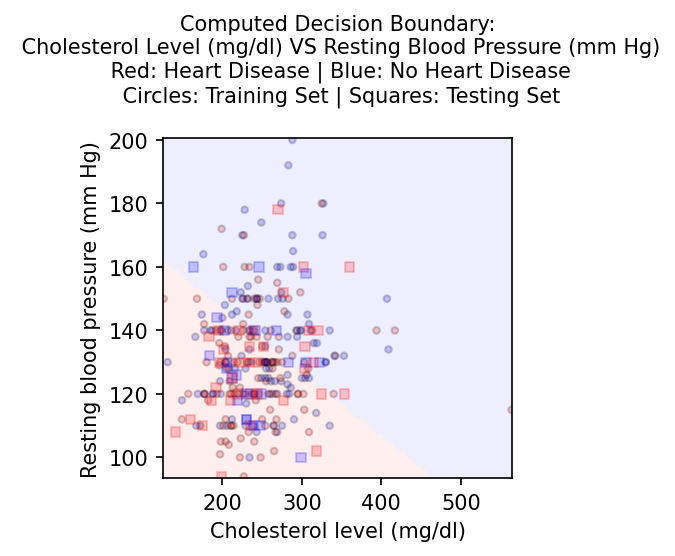

In [21]:
# We call funtion "points_plot" makes oir code efficient to re-use, as well as easier to maintain and fine-tune over time
plt.figure()
ax = plt.gca()
ax.set_ylabel('Resting blood pressure (mm Hg)')
ax.set_xlabel('Cholesterol level (mg/dl)')
ax.set_title('Computed Decision Boundary:\n ' +
             'Cholesterol Level (mg/dl) VS Resting Blood Pressure (mm Hg)' +
             '\n Red: Heart Disease | Blue: No Heart Disease' +
             '\n Circles: Training Set | Squares: Testing Set\n',
            fontsize = 10)
_ = points_plot(ax, Xtrain, Xtest, ytrain, ytest, classifier, alpha = 0.2)

We can (and should) use sklearn's classification_report() function to see more details about what the classifier is actually doing.  You should be familiar with these additional metrics. 

In [22]:
print("Classification Report for Training Data")
print(classification_report(ytrain, classifier.predict(Xtrain)))

Classification Report for Training Data
              precision    recall  f1-score   support

           0       0.57      0.70      0.63       124
           1       0.56      0.42      0.48       113

    accuracy                           0.57       237
   macro avg       0.57      0.56      0.56       237
weighted avg       0.57      0.57      0.56       237



In [23]:
print("Classification Report for Test Data")
print(classification_report(ytest, classifier.predict(Xtest)))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        36
           1       0.42      0.33      0.37        24

    accuracy                           0.55        60
   macro avg       0.52      0.51      0.51        60
weighted avg       0.53      0.55      0.54        60



#### 4.5.5 Comments on this Result

In the figure, class 0 (no heart disease) is shaded red, and class 1 (heart disease) is shaded blue.  The train labels are plotted as circles, using the same color scheme, while the test data are plotted as squares.  Some points that are evident for this simple classifier:

- The classifier tends to suggest heart disease as either blood pressure or choleterol increase.  This seems intuitively correct.
- The classifier isn't very good!  The accuracy on the training data is only 57%, and the accuracy on the testing data is barely better than random chance (55%)--where random chance if 50%.  This isn't surprising since we are using only two features.
- Moreover, notice that the classification report shows that the model performs poorly when trying to recognize inputs that belong to class 1 (*the class of interest*), which is indicated by the poor values of precision, recall, and f1-score for class 1--for the training set and test set.
- The "decision boundary" is a line. As we add more features, we won't be able to represent the boundary this way. The boundary becomes what is called a hyperplane, which is the generalization of a line into 3 or more dimensions. But here, a patient measured with a combination of cholesterol and blood pressure to the right of the line (in the blue region) would be classified as likely having heart disease.

We now move on to investigate how to get a better classifier that is optimized on the data and will perform well in the future.

### 5.1 Building a Logistic Regression Model with all Features

We will follow the same pattern we used before, only this time we are explicitly defining two objects X and y, which were defined implicitly when we built the first model.
#### 5.1.1 Define ``X`` and ``y``  

X contains the independent variables--a.k.a. features, but not the target. X is usually referred to as the "Design Matrix", in this case it will be represented as a data frame.

The following is a very convenient way to express this using Pandas--indeed, the .drop(...), means "remove the column 'num' ..."

In [24]:
X = df.drop(columns = ['num'])
print("X: ", type(X), X.shape)

X:  <class 'pandas.core.frame.DataFrame'> (297, 23)


Notice that ``X`` is a ``pandas`` DataFrame with 297 rows and 23 columns (a.k.a. a matrix).
y is the dependent variable, sometimes known as the response, target, or labels. In this case, it is the presence or absence of heart disease.

In [25]:
y = df['num']
print("y: ", type(y), y.shape)

y:  <class 'pandas.core.series.Series'> (297,)


y will have value True (1) in positions where  the value for the 'num' column of the dataframe is 1, otherwise it will be False (0). and checking the columns contain all the features but not the target.

In [26]:
list(X.columns)

['age',
 'trestbps',
 'chol',
 'fbs',
 'thalach',
 'exang',
 'oldpeak',
 'ca',
 'sex_0',
 'sex_1',
 'cp_1',
 'cp_2',
 'cp_3',
 'cp_4',
 'restecg_0',
 'restecg_1',
 'restecg_2',
 'slope_1',
 'slope_2',
 'slope_3',
 'thal_3',
 'thal_6',
 'thal_7']

#### 5.1.2 Perform train/test split on $(X, y)$

In [27]:
Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, random_state = 2)
print('Training split has ', Xlr.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ylr))+ ')')
print('Test split has ', Xtestlr.shape[0], ' rows\n',
      'and the corresponding labels have an equal number of values.', 
      '(' + str(len(ytestlr)) + ')')

Training split has  222  rows
 and the corresponding labels have an equal number of values. (222)
Test split has  75  rows
 and the corresponding labels have an equal number of values. (75)


in our first model talked about the importance of exploring the proportion among the classes in terms of their sizes, but we did not talk about what could happen to that proportion after the train/test split is executed. In our case, we saw before that the proportion between classes 0 (no heart disease), and 1 (heart disease) is about 54% for class 0, and 46% for class 1--and thus, this is a slightly imbalanced classification problem, where class 1 is the minority class. So, it makes sense to ask whether this proportion is preserved in ylr, ytestlr.

Here we define a function to plot the class ratios between two splits of the data.

In [28]:
def plot_y_ratios(y, ytest):
    fig, ax = plt.subplots(2, sharex = True)
    ax[0].bar(x = [0, 1], height = [y[y == 0].count(), 
                                    y[y == 1].count()])
    ax[0].set_ylabel('train', fontsize = 8)
    ax[0].set_ylim(0, 125)
    ax[1].bar(x = [0, 1], height = [ytest[ytest == 0].count(),
                                    ytest[ytest == 1].count()])
    ax[1].set_ylabel('test', fontsize = 8)
    ax[1].set_ylim(0, 125)
    ax[1].set_xticks([0, 1])
    ax[0].tick_params(which = 'both', labelsize = 8)
    ax[1].tick_params(which = 'both', labelsize = 8)
    ax[1].set_xlabel('heart disease\n(0 = no disease)', fontsize = 8)
    ax[0].set_title('% heart disease (where 1 means presence of heart diseases):\n' +
                    'train: ' + str(round(100 * (y[y ==1].count()/y.shape[0]), 0)) +
                    '\ntest: ' + str(round(100 * (ytest[ytest ==1].count()/ytest.shape[0]), 0)),
                   fontsize = 10)
    plt.show() 

Now we can inpsect the train response data (ylr) compared to the test response data (ytestlr).

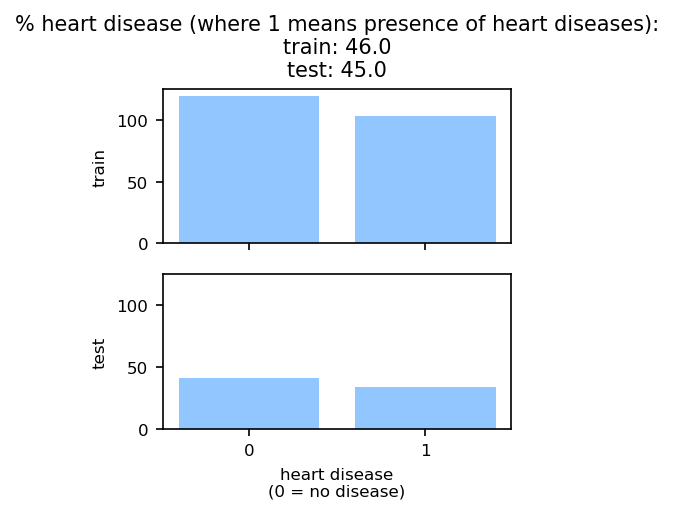

In [29]:
plot_y_ratios(ylr, ytestlr)

'ytestlr' has one point lower percentage of heart disease (45%), compared to the percentage in the original dataset (46%). train/test split made the imbalance, we would like to perform a split preserving the original proportions among the classes, so we do not have to worry about the possibility of getting poor results due to this fact.

It turns out that 'train_test_split' provides a way to compute splits that try to preserve the proportions among the classes in the original dataset.


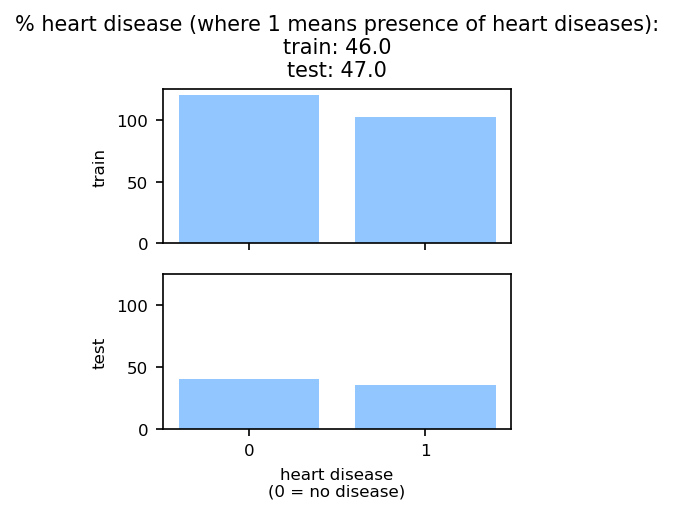

In [30]:
Xlrstrat, Xtestlrstrat, ylrstrat, ytestlrstrat = train_test_split(X, y, 
                                                                  random_state = 2, 
                                                                  stratify = y)
plot_y_ratios(ylrstrat, ytestlrstrat)

#### 5.1.3 Create an object of the class associated with the algorithm to be used--in this case LogisticRegression

Construct the LogisticRegression object, setting some basic parameters (more on this later). See (*) for more details, and discuss with your mentor the meaning of each parameter, and the implications associated with using default values

In [31]:
# Implementing regularized logistic regression using 'newton-cg'
clf = LogisticRegression(solver = 'newton-cg', max_iter = 500)

#### 5.1.4 Build an actual model using the ``fit `` method from the class associated with the algorithm to be used (using the training set)

In [32]:
clf.fit(Xlrstrat, ylrstrat)

LogisticRegression(max_iter=500, solver='newton-cg')

#### 5.1.5 Predict with the built model using the ``predict`` method from the class (training set and test set)

In [33]:
y_predict_test = clf.predict(Xtestlrstrat)
y_predict_training = clf.predict(Xlrstrat)

####  5.1.6 Compute performance metrics (in this case, accuracy) for the training and test predictions. In general, the metrics to be used and their interpretation will depend on the application at hand

In [34]:
print("[Test] Accuracy score (y_predict_test, ytestlrstrat):",
      f'{accuracy_score(y_predict_test, ytestlrstrat):.2f}')

[Test] Accuracy score (y_predict_test, ytestlrstrat): 0.81


Lets Re-compute with switched order to confirm what we expect

In [35]:
print("[Test] Accuracy score: (ytestlrstrat, y_predict_test) [**note reversed order]", 
      f'{accuracy_score(ytestlrstrat, y_predict_test):.2f}')

[Test] Accuracy score: (ytestlrstrat, y_predict_test) [**note reversed order] 0.81


And compute the metric on the training data:

In [36]:
print("[Training] Accuracy score: (ylrstrat, y_predict_training)", 
      f'{accuracy_score(ylrstrat, y_predict_training):.2f}')

[Training] Accuracy score: (ylrstrat, y_predict_training) 0.87


#### 5.1.7 Determine if the model can be improved--repeat as needed with additional algorithms and/or by applying hyper-parameter tuning

Since the model's **training accuracy** (``0.87``) is pretty good (meaning, close to 1--or 100%), then one says there is only a small "bias" in the model.

Since the model's **test accuracy** (``0.81``) is decently close to the training accuracy, we would say that there is a small "variance" between the training accuracy and the test accuracy. This is an indication that the model will "generalize well", which means that the model will be well-behaved when new data is presented to it.

Since the gap between training and testing accuracy is about 6%, one might say that the model is slightly over-fitting the data. Thus, in general, one says that a model is *over-fitting* (or just overfitting), when there is an important gap between its training performance and its test performance.

#### 5.1.8 Side-Bar: NEVER EVER use just Accuracy to Measure the Performance of a Classification Algorithm!


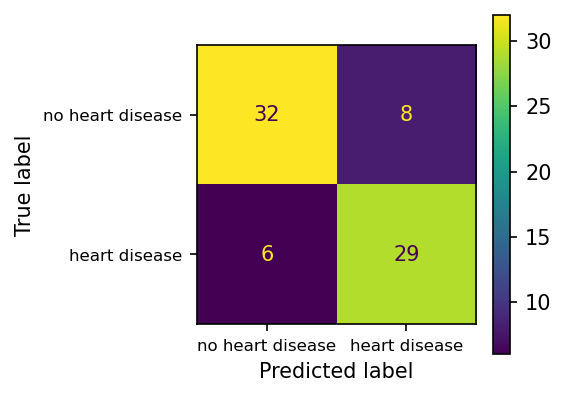

In [37]:
cm = confusion_matrix(ytestlrstrat, y_predict_test, labels = clf.classes_)
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['no heart disease', 'heart disease'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
ax.set_yticklabels(labels = ['no heart disease', 'heart disease'], fontsize = 8)
display_cm.plot(ax = ax)

This information can be discussed with stakeholders to decide which is more important, reducing false positives or false negatives.

From the chart we can see that while the overall accuracy was 81%, when we predict heart disease: 
20% of the time we are predicting a false positive.
18% we are predicting false negatives.

In [38]:
print(classification_report(ylrstrat, y_predict_training))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       120
           1       0.88      0.83      0.85       102

    accuracy                           0.87       222
   macro avg       0.87      0.87      0.87       222
weighted avg       0.87      0.87      0.87       222



In [39]:
print(classification_report(ytestlrstrat, y_predict_test))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        40
           1       0.78      0.83      0.81        35

    accuracy                           0.81        75
   macro avg       0.81      0.81      0.81        75
weighted avg       0.81      0.81      0.81        75



When the test accuracy is significally better than the training accuracy, this would justify a review of the code to see if there is a bug. In such a case, plotting the performance results with multiple splits of the same data would be one way to start investigating.

In [40]:
#
# here we try multiple splits and see the effects, with the same proportion 75% train and 25% test
#
# keep lists for training accuracy, 
#                test accuracy, 
#                and the difference between the latter and the former
#
training_accuracy = []
test_accuracy = []
accuracy_difference = []
#
# define number of trials
#
n_splits = 25
#
# define LogisticRegression object
#
clf = LogisticRegression(solver = 'newton-cg', max_iter = 500)
#
# loop over multiple trials
#
for i in range(0, n_splits):
#
# perform a split for this iteration, 
# using different random_state for every iteration
# this ensures each split is likely to be unique
#
    Xlr, Xtestlr, ylr, ytestlr = train_test_split(X, y, stratify = y, random_state = i)
#    
# fit the Classifier on the training set
#
    clf.fit(Xlr, ylr)
#
# predict the labels for the training data
#
    y_predict_training = clf.predict(Xlr)
#
# predict the labels for the test data
#
    y_predict_test = clf.predict(Xtestlr)
#
# save training set accuracy for this split
#
    tr_accuracy = accuracy_score(y_predict_training, ylr)
    training_accuracy.append(tr_accuracy)
#
# save test set accuracy for this split
#
    tst_accuracy = accuracy_score(y_predict_test, ytestlr)
    test_accuracy.append(tst_accuracy)
#
# save difference between the two acuracy values
#
    accuracy_difference.append(tst_accuracy - tr_accuracy)

The above code generates 25 unique experiments varying the train-test split indices within the original data.  Now we plot all the trials for both the training and test data, to compare the results.

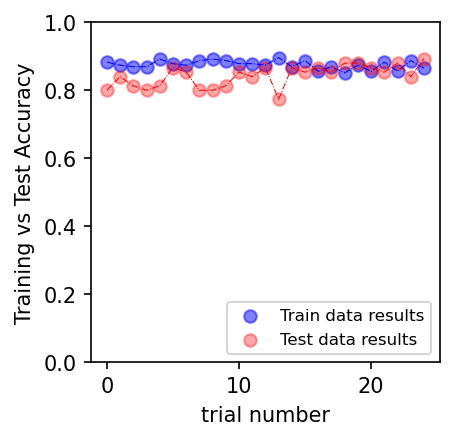

In [41]:
fig, ax = plt.subplots()
ax.scatter(range(len(training_accuracy)),
           training_accuracy, 
           color = 'blue', 
           alpha = 0.5,
           label = 'Train data results')
ax.plot(range(len(training_accuracy)),
        training_accuracy, 
        color = 'blue', 
        linestyle = '-.',
        linewidth = 0.5)
ax.scatter(range(len(test_accuracy)),
           test_accuracy, 
           color = 'red', 
           alpha = 0.35, 
           label = 'Test data results')
ax.plot(range(len(test_accuracy)),
        test_accuracy, 
        color = 'red', 
        linestyle = '-.',
        linewidth = 0.5)
ax.legend(fontsize = 8, loc = "lower right")
ax.set_ylabel('Training vs Test Accuracy')
ax.set_ylim(0, 1)
ax.set_xlabel('trial number')
plt.show()

The accuracy on the train split is relatively constant. This is generally expected since the model is given the train data to fit. On the other hand, the test results vary somewhat more. Another way to look at these results is to plot the difference between the test accuracy and the train accuracy, which is done here.

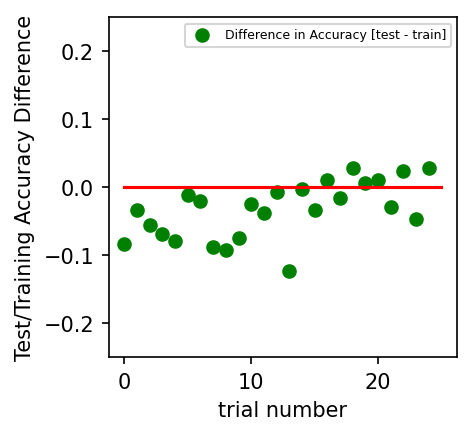

In [42]:
fig, ax = plt.subplots()
ax.scatter(range(len(accuracy_difference)),
           accuracy_difference, 
           color = 'green', 
           label = 'Difference in Accuracy [test - train]')
ax.plot([0, len(accuracy_difference)], [0, 0], 'red')
ax.legend(fontsize = 6)
ax.set_ylabel('Test/Training Accuracy Difference')
ax.set_ylim(-0.25, 0.25)
ax.set_xlabel('trial number')
plt.show()

In [43]:
print("[Training Classification Report]")
print(classification_report(ylr, y_predict_training))
#
print("[Test Classification Report]")
print(classification_report(ytestlr, y_predict_test))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       120
           1       0.88      0.82      0.85       102

    accuracy                           0.86       222
   macro avg       0.87      0.86      0.86       222
weighted avg       0.87      0.86      0.86       222

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        40
           1       0.94      0.83      0.88        35

    accuracy                           0.89        75
   macro avg       0.90      0.89      0.89        75
weighted avg       0.90      0.89      0.89        75



In this case, the test accuracy is sometimes better, but not by very much--a maximum difference of no more than 0.17 units.

#### 5.3 Summary

Logistic regression is an excellent chioce for a 'baseline' clissifier, even when you plan to test more complicated algorithms on a problem. Have a well performing baseline makes more clear when using more complex method adds value.